# Table of Contents

- [I. Import libraries](#I)
- [II. Import data](#II)
  - [1. Download data](#II.1)
  - [2. Import data](#II.2)
- [III. Clean data](#III)
- [IV. Feature Engineering](#IV)
- [V. Tree models](#V)
   - [1. Decision Tree Regressor](#V.1)
   - [2. Random Forest Regressor](#V.2)

# I. Import libraries <a name="I"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os 
import warnings

from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import graphviz 

In [2]:
# Turn off warnings
warnings.filterwarnings("ignore")

# Set printed decimal limit
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plot theme
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 4)
custom_colors = ['#512d6d', '#e6a2b4', '#6b7d96', '#b3cde0']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# II. Import data <a name="II"></a>

## 1. Download data  <a name="II.1"></a>

In [3]:
file_id = "1atOZX3YXmxx-_QebbTfndeC6U_DPTL2e" # ID of the file on Google Drive
file_name = 'Updated_data_2021&2022.csv'

%run download.ipynb

## 2. Import data <a name="II.2"></a>

In [4]:
# File path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
file_path = os.path.join(parent_dir, 'Data',file_name)

df = pd.read_csv(file_path)
df.head()

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,2021-01-01,Fri,13154,67.00,65+,M,11846,WA,37.00,NaN,1081.00,NaN,1118.00,443.55,271.25,288
1,2021-01-01,Fri,18379,54.00,45-54,M,1884,WA,40.00,NaN,NaN,NaN,40.00,0.00,40.00,1
2,2021-01-01,Fri,559232,63.00,55-64,M,2866,WA,NaN,NaN,12.00,NaN,12.00,9.50,2.04,5
3,2021-01-01,Fri,698904,69.00,65+,M,2100,WA,NaN,NaN,1223.50,NaN,1223.50,267.91,245.12,40
4,2021-01-01,Fri,762921,67.00,65+,M,4766,WA,NaN,NaN,17.50,NaN,17.50,0.00,3.50,5


# III. Clean data <a name="III"></a>

Based on our exploratory data analysis, we apply the similar steps to clean the data.

In [5]:
def clean_data(df):
    # DATE_DIM: datetime
    df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'], format='%Y-%m-%d')

    # BET_ACCOUNT_NUM_HASH: string
    df['BET_ACCOUNT_NUM_HASH'] = df['BET_ACCOUNT_NUM_HASH'].astype('O')

    # Impute AGE column
    df['AGE'].fillna(44, inplace=True)

    # More than zero
    df = df[df['TOTAL_TURNOVER'] > 0]
    
    # Drop redundant columns
    df.drop(['DAY_OF_WEEK', 'AGE'], axis=1, inplace=True)

    # Create RACING_TURNOVER column
    df['RACING_TURNOVER'] = df[['FOB_RACING_TURNOVER', 'PARI_RACING_TURNOVER']].sum(axis=1)
    
    return df.set_index('DATE_DIM')

df = clean_data(df)
df.head()

,BET_ACCOUNT_NUM_HASH,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,RACING_TURNOVER
DATE_DIM,,,,,,,,,,,,,,
2021-01-01,13154,65+,M,11846,WA,37.00,NaN,1081.00,NaN,1118.00,443.55,271.25,288,1118.00
2021-01-01,18379,45-54,M,1884,WA,40.00,NaN,NaN,NaN,40.00,0.00,40.00,1,40.00
2021-01-01,559232,55-64,M,2866,WA,NaN,NaN,12.00,NaN,12.00,9.50,2.04,5,12.00
2021-01-01,698904,65+,M,2100,WA,NaN,NaN,1223.50,NaN,1223.50,267.91,245.12,40,1223.50
2021-01-01,762921,65+,M,4766,WA,NaN,NaN,17.50,NaN,17.50,0.00,3.50,5,17.50


# IV. Feature Engineering <a name="IV"></a>

We create a dataframe containing all demographic categorical factors: `AGE_BAND`, `GENDER`, `RESIDENTIAL_STATE`

In [6]:
# Create customer demographic info dataframe
def cus_aggregate(df):
    cus_df = df.groupby('BET_ACCOUNT_NUM_HASH').agg({'AGE_BAND':min, 'GENDER': min, 'RESIDENTIAL_STATE':min})
    return cus_df

cus_df = cus_aggregate(df)
cus_df.head()

,AGE_BAND,GENDER,RESIDENTIAL_STATE
BET_ACCOUNT_NUM_HASH,,,
13154,65+,M,WA
18379,45-54,M,WA
37251,18-24,U,WA
129273,18-24,U,WA
348318,25-34,U,WA


We extract behaviorial variables that could impact future spending:
- Frequency ([0-1])
- Racing spending ratio ([0-1])
- Dividends paid ratio (>0)
- Average turnover per day
- Average tickets purchased per day

We go back 1 week, 4 weeks and 12 weeks. Along with demographic data, here is the list of columns to be created and treated as independent variables.

Out predicted (dependent) variables will be the average turnover per day for the next 4 week.

| Column | Description |
|-----------------|-----------------|
| AGE_BAND | Customer’s age band as of Wager date | 
| GENDER | Customer’s gender (M, F, U) | 
| RESIDENTIAL_STATE | Residential state where the customer resides | 
| AVG_FREQ_12 | Betting frequency of the last 12 weeks [0-1] |
| RACING_RATIO_12 | Racing spending ratio of the last 12 weeks [0-1]|
| AVG_TURNOVER_12 | Average turnover per day for the last 12 weeks|
| DIVIDENDS_RATIO_12 |Dividends paid of the last 12 weeks|
| AVG_TICKETS_12 |Average tickets purchased per day for the last 12 weeks|
| AVG_FREQ_4 | Betting frequency of the last 4 weeks [0-1] |
| RACING_RATIO_4 | Racing spending ratio of the last 4 weeks [0-1]|
| AVG_TURNOVER_4 | Average turnover per day for the last 4 weeks|
| DIVIDENDS_RATIO_4 |Dividends paid of the last 4 weeks|
| AVG_TICKETS_4 |Average tickets purchased per day for the last 4 weeks|
| AVG_FREQ_1 | Betting frequency of the last week [0-1] |
| RACING_RATIO_1 | Racing spending ratio of the last week [0-1]|
| AVG_TURNOVER_1 | Average turnover per day for the last week|
| DIVIDENDS_RATIO_1 |Dividends paid of the last week|
| AVG_TICKETS_1 |Average tickets purchased per day for the last week|
| AVG_TURNOVER |Average turnover per day for the next 4 weeks|

In [7]:
def weekly_aggregate(df, date='2021-05-10', weeks=4):
    # Filtered period
    past_date = (datetime.strptime(date, '%Y-%m-%d') - timedelta(weeks=weeks)).strftime('%Y-%m-%d')
    
    # Aggregate
    agg_df = df[(df.index >= past_date ) & (df.index < date)].groupby('BET_ACCOUNT_NUM_HASH').agg({
        'BET_ACCOUNT_NUM_HASH': np.size,
        'TENURE_IN_DAYS' : max,
        'RACING_TURNOVER': sum,
        'TOTAL_TURNOVER' : sum,
        'DIVIDENDS_PAID' : sum,
        'TICKETS' : sum
    })
    
    # Create ratio columns
    agg_df['RACING_TURNOVER'] = agg_df['RACING_TURNOVER'] / agg_df['TOTAL_TURNOVER']
    agg_df['DIVIDENDS_PAID'] = agg_df['DIVIDENDS_PAID'] / agg_df['TOTAL_TURNOVER']

    # Create average columns
    agg_df[['BET_ACCOUNT_NUM_HASH', 'TOTAL_TURNOVER', 'TICKETS']] = agg_df[['BET_ACCOUNT_NUM_HASH', 'TOTAL_TURNOVER', 'TICKETS']] / (weeks*7)
    
    agg_df.columns = ['AVG_FREQ_' + str(weeks), 
                     'TENURE_IN_DAYS_' + str(weeks), 
                     'RACING_RATIO_' + str(weeks),
                     'AVG_TURNOVER_' + str(weeks),
                     'DIVIDENDS_RATIO_' + str(weeks),
                     'AVG_TICKETS_' + str(weeks)]
    
    return agg_df

def total_aggregate(df, date='2021-05-10'):
    # Prediction (4 weeks after the current week)
    future_date = (datetime.strptime(date, '%Y-%m-%d') + timedelta(weeks=4)).strftime('%Y-%m-%d')
    pred = df[ (df.index >= date ) & (df.index < future_date)].groupby('BET_ACCOUNT_NUM_HASH').TOTAL_TURNOVER.sum().to_frame() / 28
    pred.columns = ['AVG_TURNOVER']
    
    # Aggregate
    train_12 = weekly_aggregate(df,date=date, weeks=12)
    train_4 = weekly_aggregate(df,date=date, weeks=4)
    train_1 = weekly_aggregate(df,date=date, weeks=1)
    
    # Filter new customers
    train_12 = train_12[train_12['TENURE_IN_DAYS_12'] >= 84]
    
    # Join data
    train = pd.merge(train_12, train_4, left_index=True, right_index=True, how='left')
    train = pd.merge(train, train_1, left_index=True, right_index=True, how='left')
    train = pd.merge(train, pred, left_index=True, right_index=True, how='left')

    # Drop TENURE_IN_DAYS columns
    train.drop(['TENURE_IN_DAYS_12', 'TENURE_IN_DAYS_4', 'TENURE_IN_DAYS_1'], axis=1, inplace=True)
    
    # Fill na
    train.fillna(0, inplace=True)
    
    return train

In [8]:
# Choose 2021-05-10'
date='2021-05-10'
train = total_aggregate(df, date=date)

# Join with cus_df to get categorical data
train = pd.merge(train, cus_df, left_index=True, right_index=True, how='left')

# Preview
train.head()

,AVG_FREQ_12,RACING_RATIO_12,AVG_TURNOVER_12,DIVIDENDS_RATIO_12,AVG_TICKETS_12,AVG_FREQ_4,RACING_RATIO_4,AVG_TURNOVER_4,DIVIDENDS_RATIO_4,AVG_TICKETS_4,AVG_FREQ_1,RACING_RATIO_1,AVG_TURNOVER_1,DIVIDENDS_RATIO_1,AVG_TICKETS_1,AVG_TURNOVER,AGE_BAND,GENDER,RESIDENTIAL_STATE
BET_ACCOUNT_NUM_HASH,,,,,,,,,,,,,,,,,,,
13154,0.74,1.00,767.26,0.77,238.87,0.71,1.00,789.65,0.68,229.96,0.71,1.00,979.19,0.79,293.29,913.25,65+,M,WA
18379,0.19,1.00,34.29,0.94,0.71,0.11,1.00,18.93,1.31,0.61,0.14,1.00,14.29,3.15,0.29,28.71,45-54,M,WA
385032,0.01,1.00,0.04,0.00,0.02,0.04,1.00,0.11,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.57,25-34,U,WA
433164,0.36,1.00,53.97,0.87,102.27,0.46,1.00,96.17,0.98,185.00,0.71,1.00,22.50,0.15,44.43,26.38,35-44,U,WA
559232,0.38,1.00,9.61,0.94,2.62,0.50,0.99,15.39,1.14,4.18,0.00,0.00,0.00,0.00,0.00,17.79,55-64,M,WA


In [9]:
# Create X and y
X = train.drop('AVG_TURNOVER', axis=1)
y = train['AVG_TURNOVER']

# Evaluation dataframe
eva_df = pd.DataFrame(columns = ["Model", "MSE", "MAE", "R2" ])

In [10]:
# Choose independent variables
cat_cols = ['AGE_BAND', 'GENDER', 'RESIDENTIAL_STATE']

num_cols = ['AVG_FREQ_12','RACING_RATIO_12','AVG_TURNOVER_12','DIVIDENDS_RATIO_12', 'AVG_TICKETS_12', 'AVG_FREQ_4', 'RACING_RATIO_4', 
            'AVG_TURNOVER_4','DIVIDENDS_RATIO_4','AVG_TICKETS_4','AVG_FREQ_1','RACING_RATIO_1','AVG_TURNOVER_1','DIVIDENDS_RATIO_1','AVG_TICKETS_1']

# Transform columns
one_hot_encoder = OneHotEncoder(sparse = False)

full_pipeline = ColumnTransformer([
    ("cat", one_hot_encoder, cat_cols),
    ("num", "passthrough", num_cols),
])

In [11]:
# Transform
X_trans = full_pipeline.fit_transform(X)
y = y.values.reshape(-1,1)

# V. Tree model <a name="V"></a>

## 1. Decicison Tree Regressor <a name="V.1"></a>

A decision tree regressor works by constructing a tree-like model where each internal node represents a decision based on a specific feature and a corresponding threshold value. The leaf nodes of the tree contain the predicted output values.

In [12]:
tree_reg = DecisionTreeRegressor()

param_grid = {
    'max_depth' : range(3,26),
    'min_weight_fraction_leaf' : [0.03,0.05,0.10]
}

tree_reg_grid = GridSearchCV(estimator=tree_reg, param_grid=param_grid, cv=10)
tree_reg_grid.fit(X_trans, y)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(3, 26),
                         'min_weight_fraction_leaf': [0.03, 0.05, 0.1]})

In [13]:
best_params = tree_reg_grid.best_params_
best_params

{'max_depth': 12, 'min_weight_fraction_leaf': 0.03}

In [14]:
# K-fold cross validation with k=10
tree_reg = DecisionTreeRegressor(**best_params)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(tree_reg, X_trans, y, cv=kfold, scoring = ['neg_mean_squared_error','neg_mean_absolute_error', 'r2'] )

In [15]:
# Add to evaluation dataframe
mse = -scores['test_neg_mean_squared_error'].mean()
mae = -scores['test_neg_mean_absolute_error'].mean()
R2 = scores['test_r2'].mean()

eva_df = eva_df.append({"Model": "Decision tree regressor", "MSE" : mse, "MAE": mae, "R2" : R2},ignore_index=True)
eva_df

,Model,MSE,MAE,R2
0,Decision tree regressor,23492.29,26.91,0.36


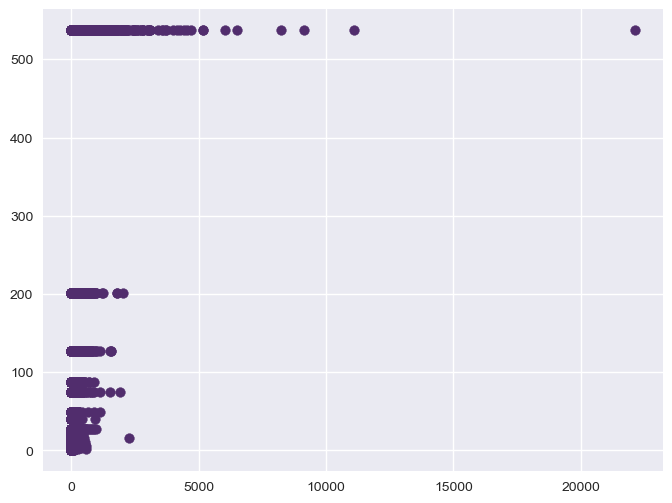

In [16]:
y_pred = tree_reg.predict(X_trans)

plt.figure(figsize=(8,6))
plt.scatter(y,y_pred)

## 2. Random Forest Regressor <a name="V.2"></a>

The Random Forest Regressor is a machine learning algorithm that belongs to the ensemble learning family. It is designed for regression tasks and is based on the concept of decision trees. Random Forest combines the predictions from multiple decision trees to make more accurate and robust predictions.

In [17]:
rf_reg = RandomForestRegressor(n_estimators=500, max_depth= 12, min_weight_fraction_leaf= 0.03, random_state=42)
rf_reg.fit(X_trans, y)

RandomForestRegressor(max_depth=12, min_weight_fraction_leaf=0.03,
                      n_estimators=500, random_state=42)

In [18]:
y_pred = rf_reg.predict(X_trans)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
R2 = r2_score(y, y_pred)

In [19]:
eva_df = eva_df.append({"Model": "Random forest regressor", "MSE" : mse, "MAE": mae, "R2" : R2},ignore_index=True)
eva_df

,Model,MSE,MAE,R2
0,Decision tree regressor,23492.29,26.91,0.36
1,Random forest regressor,23389.38,26.41,0.29


Text(0.5, 0, 'Real')

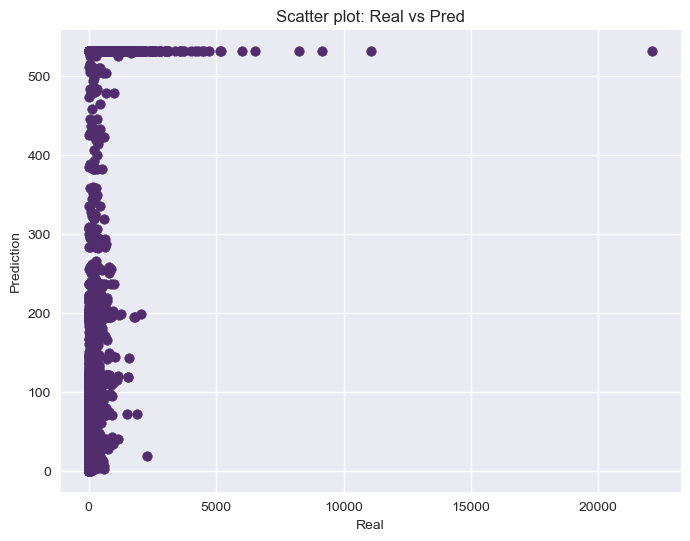

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(y,y_pred)
plt.title('Scatter plot: Real vs Pred')
plt.ylabel('Prediction')
plt.xlabel('Real')